In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/model_line.zip' -d '/content/drive/MyDrive/model_line'

Archive:  /content/drive/MyDrive/model_line.zip
   creating: /content/drive/MyDrive/model_line/model_line/
   creating: /content/drive/MyDrive/model_line/model_line/band/
  inflating: /content/drive/MyDrive/model_line/model_line/band/test_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/train_band_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/high/
  inflating: /content/drive/MyDrive/model_line/model_line/high/test_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/train_high_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/high/valid_high_line.csv  
   creating: /content/drive/MyDrive/model_line/model_line/low/
  inflating: /content/drive/MyDrive/model_line/model_line/low/test_low_line.csv  
  inflating: /content/drive/MyDrive/model_line/model_line/low/train_low_line.csv  
  inflating: /content/drive/M

In [30]:
import os
import itertools
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score

In [31]:
import tqdm, re, sys
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

In [97]:
data_train = pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/train_band_line.csv', header=None)
data_test = pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/test_band_line.csv', header=None)
data_val= pd.read_csv('/content/drive/MyDrive/model_line/model_line/band/valid_band_line.csv', header=None)

In [98]:
data_test

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.013974,-0.011168,-0.009118,-0.008067,-0.008125,-0.009210,-0.011005,-0.012983,-0.014471,-0.014771,...,0.006733,0.009824,0.013030,0.016239,0.019380,0.022418,0.025327,0.028062,0.030516,0.032514
1,-0.168748,-0.165213,-0.162149,-0.159616,-0.157617,-0.156088,-0.154895,-0.153851,-0.152741,-0.151345,...,-0.112212,-0.109266,-0.106187,-0.103433,-0.101427,-0.100452,-0.100579,-0.101653,-0.103329,-0.105151
2,-0.065523,-0.063387,-0.062618,-0.063184,-0.064857,-0.067233,-0.069777,-0.071909,-0.073104,-0.072994,...,-0.108012,-0.104863,-0.102909,-0.101926,-0.101481,-0.101056,-0.100197,-0.098638,-0.096375,-0.093669
3,0.517435,0.633848,0.709706,0.733996,0.703265,0.622346,0.503432,0.363695,0.221988,0.095392,...,-0.079957,-0.067902,-0.046360,-0.023911,-0.006614,0.002560,0.003524,-0.001689,-0.009950,-0.018044
4,-0.069052,-0.066942,-0.064951,-0.062974,-0.060851,-0.058435,-0.055658,-0.052576,-0.049378,-0.046363,...,-0.134398,-0.135559,-0.138471,-0.142558,-0.147015,-0.150950,-0.153535,-0.154163,-0.152557,-0.148830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.004594,0.009590,0.017135,0.025880,0.034416,0.041620,0.046867,0.050103,0.051777,0.052674,...,0.045016,0.016083,-0.009705,-0.032355,-0.052129,-0.069386,-0.084460,-0.097612,-0.109031,-0.118868
5996,0.017135,0.017694,0.019432,0.022356,0.026302,0.030971,0.035976,0.040891,0.045291,0.048799,...,0.005152,0.044268,0.089211,0.134152,0.171846,0.194955,0.197629,0.176948,0.133840,0.073184
5997,-0.061678,-0.060521,-0.059365,-0.058206,-0.057080,-0.056067,-0.055283,-0.054843,-0.054816,-0.055175,...,-0.046773,-0.050592,-0.052317,-0.052018,-0.049965,-0.046587,-0.042433,-0.038139,-0.034393,-0.031913
5998,-0.039287,-0.039374,-0.039054,-0.038510,-0.037933,-0.037494,-0.037327,-0.037532,-0.038153,-0.039167,...,-0.058137,-0.060069,-0.061489,-0.061986,-0.061385,-0.059834,-0.057803,-0.055972,-0.055062,-0.055631


In [99]:
data_train.shape

(24000, 256)

## 라벨생성

In [100]:
arr = np.array([])

for i in range(1,101):
  for j in range(240):
    arr = np.append(arr, np.array([i]))

In [101]:
data_train[256]=arr

In [102]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.035003,-0.034647,-0.033418,-0.031305,-0.028545,-0.025565,-0.022868,-0.020891,-0.019891,1.0
1,-0.019872,-0.020594,-0.021637,-0.022515,-0.022798,-0.022202,-0.020644,-0.018236,-0.015233,-0.011971,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
2,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.059447,-0.057278,-0.056011,-0.055424,-0.055246,-0.055239,-0.055275,-0.055352,-0.055577,1.0
3,-0.056099,-0.057035,-0.058395,-0.060043,-0.061694,-0.062967,-0.063465,-0.062887,-0.061116,-0.058272,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
4,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.150072,0.164082,0.180535,0.199168,0.219491,0.240843,0.262473,0.283635,0.303673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.043512,0.020932,0.001382,-0.014947,-0.027957,-0.037670,-0.044270,-0.048123,-0.049775,-0.049906,...,-0.020100,-0.018824,-0.018132,-0.018247,-0.019303,-0.021303,-0.024082,-0.027314,-0.030559,100.0
23996,-0.076867,-0.083002,-0.088128,-0.091454,-0.092582,-0.091623,-0.089189,-0.086281,-0.084051,-0.083490,...,-0.019352,-0.019054,-0.016308,-0.011295,-0.004783,0.002224,0.008807,0.014368,0.018726,100.0
23997,0.022090,0.024929,0.027786,0.031100,0.035075,0.039622,0.044402,0.048933,0.052740,0.055510,...,-0.053679,-0.057318,-0.059515,-0.061043,-0.062554,-0.064528,-0.067243,-0.070758,-0.074902,100.0
23998,-0.079288,-0.083358,-0.086464,-0.087995,-0.087513,-0.084880,-0.080336,-0.074488,-0.068211,-0.062467,...,-0.066882,-0.067113,-0.068424,-0.070704,-0.073600,-0.076563,-0.078930,-0.080050,-0.079413,100.0


In [103]:
arr_t = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_t = np.append(arr_t, np.array([i]))

In [104]:
arr_v = np.array([])

for i in range(1,101):
  for j in range(60):
    arr_v = np.append(arr_v, np.array([i]))

In [105]:
data_test[256]=arr_t
data_val[256]=arr_v
data_val

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.054004,-0.050825,-0.048322,-0.046824,-0.046532,-0.047445,-0.049330,-0.051735,-0.054058,-0.055645,...,-0.028530,-0.029492,-0.029945,-0.029648,-0.028487,-0.026485,-0.023782,-0.020603,-0.017228,1.0
1,-0.209505,-0.208403,-0.206688,-0.204586,-0.202338,-0.200196,-0.198379,-0.197017,-0.196097,-0.195447,...,-0.205948,-0.202740,-0.198907,-0.194673,-0.190228,-0.185713,-0.181227,-0.176850,-0.172660,1.0
2,-0.067735,-0.065806,-0.063513,-0.060990,-0.058453,-0.056174,-0.054439,-0.053477,-0.053402,-0.054158,...,-0.093394,-0.093535,-0.092581,-0.090373,-0.086983,-0.082689,-0.077914,-0.073148,-0.068878,1.0
3,-0.002916,-0.007004,-0.012949,-0.020332,-0.028344,-0.035829,-0.041422,-0.043775,-0.041865,-0.035337,...,-0.097242,-0.124400,-0.137850,-0.128147,-0.087559,-0.012153,0.096530,0.230711,0.376848,1.0
4,-0.028844,-0.028027,-0.028309,-0.029364,-0.030767,-0.032072,-0.032878,-0.032899,-0.032005,-0.030247,...,-0.074225,-0.075851,-0.077197,-0.077950,-0.077920,-0.077074,-0.075531,-0.073514,-0.071283,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.015685,0.016545,0.014765,0.010665,0.004884,-0.001771,-0.008494,-0.014652,-0.019878,-0.024092,...,-0.052522,-0.020671,0.001335,0.013226,0.016606,0.014270,0.009428,0.004988,0.003041,100.0
5996,-0.171624,-0.175496,-0.177258,-0.176626,-0.173694,-0.168915,-0.163017,-0.156862,-0.151287,-0.146943,...,0.013368,0.016800,0.019352,0.020889,0.021392,0.020985,0.019940,0.018650,0.017569,100.0
5997,0.000168,-0.001110,-0.003542,-0.006028,-0.007548,-0.007396,-0.005302,-0.001433,0.003712,0.009473,...,-0.072272,-0.071268,-0.070220,-0.069094,-0.067885,-0.066618,-0.065335,-0.064074,-0.062856,100.0
5998,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.036757,-0.033683,-0.032034,-0.031757,-0.032584,-0.034107,-0.035874,-0.037486,-0.038665,100.0


In [11]:
# y_train = arr
# y_test = arr_t
# y_val = arr_v

## 데이터 전체 섞기

In [106]:
data_total=pd.concat([data_train, data_test, data_val])
data_total

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.031820,-0.015874,-0.001172,0.011249,0.020713,0.026974,0.030190,0.030831,0.029559,0.027102,...,-0.035003,-0.034647,-0.033418,-0.031305,-0.028545,-0.025565,-0.022868,-0.020891,-0.019891,1.0
1,-0.019872,-0.020594,-0.021637,-0.022515,-0.022798,-0.022202,-0.020644,-0.018236,-0.015233,-0.011971,...,-0.072854,-0.070401,-0.067539,-0.064716,-0.062285,-0.060443,-0.059208,-0.058448,-0.057940,1.0
2,-0.057454,-0.056822,-0.055984,-0.054985,-0.053945,-0.052999,-0.052250,-0.051733,-0.051414,-0.051213,...,-0.059447,-0.057278,-0.056011,-0.055424,-0.055246,-0.055239,-0.055275,-0.055352,-0.055577,1.0
3,-0.056099,-0.057035,-0.058395,-0.060043,-0.061694,-0.062967,-0.063465,-0.062887,-0.061116,-0.058272,...,-0.071806,-0.071741,-0.071302,-0.070367,-0.068861,-0.066758,-0.064085,-0.060936,-0.057487,1.0
4,0.053295,0.053439,0.055066,0.059409,0.067278,0.078961,0.094216,0.112361,0.132422,0.153321,...,0.150072,0.164082,0.180535,0.199168,0.219491,0.240843,0.262473,0.283635,0.303673,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.015685,0.016545,0.014765,0.010665,0.004884,-0.001771,-0.008494,-0.014652,-0.019878,-0.024092,...,-0.052522,-0.020671,0.001335,0.013226,0.016606,0.014270,0.009428,0.004988,0.003041,100.0
5996,-0.171624,-0.175496,-0.177258,-0.176626,-0.173694,-0.168915,-0.163017,-0.156862,-0.151287,-0.146943,...,0.013368,0.016800,0.019352,0.020889,0.021392,0.020985,0.019940,0.018650,0.017569,100.0
5997,0.000168,-0.001110,-0.003542,-0.006028,-0.007548,-0.007396,-0.005302,-0.001433,0.003712,0.009473,...,-0.072272,-0.071268,-0.070220,-0.069094,-0.067885,-0.066618,-0.065335,-0.064074,-0.062856,100.0
5998,-0.033347,-0.035287,-0.036169,-0.036014,-0.035070,-0.033744,-0.032503,-0.031760,-0.031802,-0.032746,...,-0.036757,-0.033683,-0.032034,-0.031757,-0.032584,-0.034107,-0.035874,-0.037486,-0.038665,100.0


In [107]:
data_total=data_total.sample(frac=1)

In [114]:
data_train=data_total.iloc[0:24000, :]
data_val=data_total.iloc[24000:30000, :]
data_test=data_total.iloc[30000:36000,:]

In [118]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
8186,-0.037284,-0.048329,-0.058503,-0.066508,-0.071368,-0.072684,-0.070804,-0.066825,-0.062381,-0.059243,...,-0.021985,-0.025304,-0.025911,-0.023381,-0.018003,-0.010586,-0.002185,0.006173,0.013717,35.0
22366,-0.048650,-0.046037,-0.044587,-0.044697,-0.046334,-0.049051,-0.052100,-0.054617,-0.055818,-0.055133,...,-0.049419,-0.054545,-0.059189,-0.063132,-0.066046,-0.067585,-0.067532,-0.065958,-0.063339,94.0
2073,-0.053469,-0.053767,-0.054011,-0.053957,-0.053552,-0.052913,-0.052275,-0.051902,-0.052026,-0.052796,...,-0.064871,-0.063712,-0.063389,-0.063397,-0.063330,-0.063018,-0.062562,-0.062272,-0.062536,35.0
2362,0.014389,0.006160,-0.003319,-0.013071,-0.022208,-0.030060,-0.036255,-0.040736,-0.043698,-0.045473,...,-0.011709,-0.006964,-0.001897,0.002268,0.004178,0.002571,-0.003447,-0.014101,-0.028685,10.0
20763,-0.058815,-0.053162,-0.050717,-0.052377,-0.058015,-0.066290,-0.074691,-0.079874,-0.078268,-0.066847,...,0.187426,0.202641,0.217023,0.230066,0.241300,0.250288,0.256632,0.259989,0.260097,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,0.057892,0.093805,0.125524,0.147787,0.156261,0.148579,0.125013,0.088562,0.044412,-0.001104,...,0.149146,0.150563,0.149662,0.146883,0.142828,0.138163,0.133499,0.129270,0.125641,23.0
12473,0.103140,0.109886,0.118222,0.127966,0.138690,0.149822,0.160802,0.171216,0.180884,0.189845,...,-0.070612,-0.071272,-0.071076,-0.069987,-0.068142,-0.065822,-0.063398,-0.061259,-0.059726,52.0
4511,0.146784,0.158052,0.169187,0.180183,0.190975,0.201434,0.211381,0.220605,0.228876,0.235954,...,-0.081064,-0.078343,-0.076061,-0.074344,-0.073239,-0.072720,-0.072703,-0.073073,-0.073707,19.0
14092,0.050343,0.046299,0.043145,0.041575,0.041935,0.044167,0.047860,0.052387,0.057080,0.061397,...,-0.059215,-0.056776,-0.055660,-0.055843,-0.057051,-0.058847,-0.060763,-0.062417,-0.063609,59.0


## 데이터 따로 섞기

In [45]:
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_val = data_val.sample(frac=1).reset_index(drop=True)

In [50]:
data_train

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,0.013167,0.017490,0.018646,0.016446,0.011114,0.003245,-0.006287,-0.016464,-0.026283,-0.034921,...,-0.004174,-0.002091,0.000968,0.004741,0.008918,0.013208,0.017364,0.021204,0.024627,72.0
1,-0.115512,-0.115289,-0.113396,-0.110355,-0.106877,-0.103780,-0.101890,-0.101913,-0.104281,-0.108999,...,0.008242,0.022894,0.039154,0.056616,0.074825,0.093340,0.111823,0.130108,0.148236,54.0
2,-0.009042,-0.008103,-0.008920,-0.010897,-0.013278,-0.015248,-0.016029,-0.014967,-0.011609,-0.005777,...,-0.041403,-0.040630,-0.041345,-0.043381,-0.046298,-0.049451,-0.052130,-0.053720,-0.053853,61.0
3,0.402142,0.302911,0.185292,0.066715,-0.037182,-0.115259,-0.162345,-0.179306,-0.171868,-0.148656,...,-0.079294,-0.081055,-0.082744,-0.083994,-0.084521,-0.084185,-0.083029,-0.081281,-0.079306,40.0
4,-0.007963,0.005535,0.017452,0.026380,0.031221,0.031279,0.026293,0.016416,0.002152,-0.015730,...,0.008343,-0.091526,-0.188443,-0.269607,-0.325108,-0.349555,-0.342722,-0.309150,-0.256869,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,-0.109838,-0.112002,-0.113641,-0.114621,-0.114863,-0.114353,-0.113177,-0.111554,-0.109847,-0.108525,...,-0.108024,-0.108699,-0.108706,-0.108044,-0.106867,-0.105405,-0.103864,-0.102335,-0.100754,62.0
23996,-0.040675,-0.054378,-0.068501,-0.081380,-0.091338,-0.096999,-0.097585,-0.093149,-0.084687,-0.074089,...,0.001157,0.069442,0.143595,0.214329,0.271583,0.306394,0.312725,0.288831,0.237771,41.0
23997,-0.019681,-0.041208,-0.061138,-0.078153,-0.091414,-0.100656,-0.106163,-0.108632,-0.108992,-0.108220,...,-0.045588,-0.048637,-0.051353,-0.053427,-0.054666,-0.054988,-0.054436,-0.053175,-0.051491,35.0
23998,0.003074,-0.012424,-0.024224,-0.032849,-0.039069,-0.043762,-0.047765,-0.051742,-0.056075,-0.060821,...,-0.119279,-0.118505,-0.116912,-0.114928,-0.113008,-0.111522,-0.110699,-0.110611,-0.111212,98.0


## 전처리

In [119]:
y_train = to_categorical(data_train[256])
y_test = to_categorical(data_test[256])
y_val = to_categorical(data_val[256])
# y_train = to_categorical(arr)
# y_test = to_categorical(arr_t)
# y_val = to_categorical(arr_v)
y_train[23999]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
data_train.drop([256], axis=1, inplace=True)
data_test.drop([256], axis=1, inplace=True)
data_val.drop([256], axis=1, inplace=True)
data_train

In [121]:
X_train=data_train.values
X_test=data_test.values
X_val=data_val.values

In [122]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(24000, 256)
(6000, 256)
(6000, 256)
(24000, 101)
(6000, 101)
(6000, 101)


In [123]:
# X_train = X_train.reshape(1, 256, 24000)
# X_test = X_test.reshape(1, 256, 6000)
# X_val = X_val.reshape(1, 256, 6000)
X_train = X_train.reshape(24000, 256, 1)
X_test = X_test.reshape(6000, 256, 1)
X_val = X_val.reshape(6000, 256, 1)
X_train.shape, X_test.shape, X_val.shape

((24000, 256, 1), (6000, 256, 1), (6000, 256, 1))

## cnn-lstm 모델

In [ ]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(256, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    #model.add(Dense(64, activation='relu'))
    #model.add(Dense(64, activation='relu'))
    model.add(Dense(101, activation='softmax'))
    
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [ ]:
model = model()
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_17 (Conv1D)          (None, 256, 64)           448       
                                                                 
 batch_normalization_12 (Bat  (None, 256, 64)          256       
 chNormalization)                                                
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 128, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 batch_normalization_13 (Bat  (None, 128, 64)          256       
 chNormalization)                                                
                                                     

## cnn-gru 모델

In [ ]:
from keras.layers import Input, Embedding, GRU, LSTM, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()

model.add(Conv1D(filters=64, kernel_size=6, activation='relu', padding='same', input_shape=(256, 1)))
model.add(SpatialDropout1D(0.2))
model.add(MaxPooling1D(4))
model.add(CuDNNGRU(64))

model.add(Dropout(0.1))
model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 256, 64)           448       
                                                                 
 spatial_dropout1d_4 (Spatia  (None, 256, 64)          0         
 lDropout1D)                                                     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 cu_dnngru_4 (CuDNNGRU)      (None, 64)                24960     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 101)              

## gru모델

In [124]:
model = Sequential()
model.add(GRU(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(GRU(units=50, return_sequences=True))
model.add(GRU(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 256, 100)          30900     
                                                                 
 gru_4 (GRU)                 (None, 256, 50)           22800     
                                                                 
 gru_5 (GRU)                 (None, 256, 50)           15300     
                                                                 
 flatten_8 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_8 (Dropout)         (None, 12800)             0         
                                                                 
 dense_10 (Dense)            (None, 101)               1292901   
                                                                 
Total params: 1,361,901
Trainable params: 1,361,901
No

## LSTM

In [60]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.1))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 256, 100)          40800     
                                                                 
 lstm_4 (LSTM)               (None, 256, 50)           30200     
                                                                 
 lstm_5 (LSTM)               (None, 256, 50)           20200     
                                                                 
 flatten_6 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_6 (Dropout)         (None, 12800)             0         
                                                                 
 dense_8 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,384,101
Trainable params: 1,384,101
No

## RNN모델

In [26]:
from keras.layers import Input, Embedding, GRU, LSTM, SimpleRNN, MaxPooling1D, GlobalMaxPool1D, CuDNNGRU
from keras.layers import Dropout, Dense, Activation, Flatten, Conv1D, SpatialDropout1D
from keras.models import Sequential

model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(256,1))) #shape[1]=열
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(SimpleRNN(units=50, return_sequences=True))

model.add(Flatten())
model.add(Dropout(0.2))

model.add(Dense(101, activation='softmax'))
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_12 (SimpleRNN)   (None, 256, 100)          10200     
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 256, 50)           7550      
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 50)           5050      
                                                                 
 flatten_4 (Flatten)         (None, 12800)             0         
                                                                 
 dropout_4 (Dropout)         (None, 12800)             0         
                                                                 
 dense_5 (Dense)             (None, 101)               1292901   
                                                                 
Total params: 1,315,701
Trainable params: 1,315,701
No

## 모델학습/평가

In [125]:
history = model.fit(X_train, y_train, batch_size = 512, epochs = 400, verbose = 1, validation_data=(X_val, y_val))

Epoch 1/400
47/47 [==============================] - 9s 93ms/step - loss: 0.0098 - accuracy: 0.0105 - val_loss: 0.0098 - val_accuracy: 0.0102
Epoch 2/400
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0106 - val_loss: 0.0098 - val_accuracy: 0.0070
Epoch 3/400
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0113 - val_loss: 0.0098 - val_accuracy: 0.0087
Epoch 4/400
47/47 [==============================] - 3s 74ms/step - loss: 0.0098 - accuracy: 0.0123 - val_loss: 0.0098 - val_accuracy: 0.0112
Epoch 5/400
47/47 [==============================] - 3s 75ms/step - loss: 0.0098 - accuracy: 0.0160 - val_loss: 0.0098 - val_accuracy: 0.0118
Epoch 6/400
47/47 [==============================] - 4s 75ms/step - loss: 0.0098 - accuracy: 0.0202 - val_loss: 0.0098 - val_accuracy: 0.0250
Epoch 7/400
47/47 [==============================] - 4s 75ms/step - loss: 0.0098 - accuracy: 0.0343 - val_loss: 0.0098 - val_accuracy: 0.0315
Epoch 

In [126]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 2s 10ms/step - loss: 0.0016 - accuracy: 0.9092


[0.0015850046183913946, 0.909166693687439]

## 그래프 분석

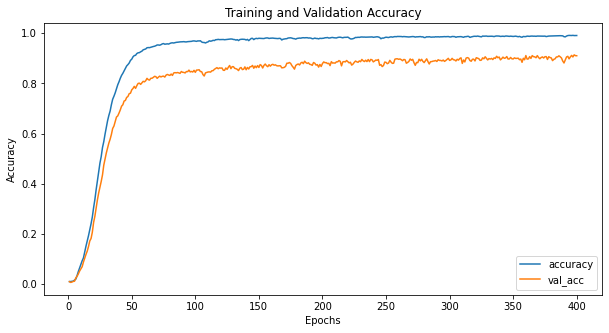

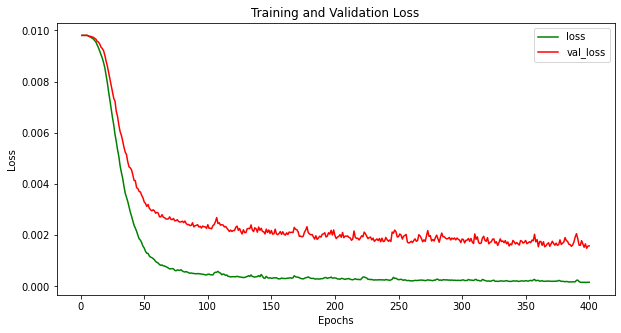

In [127]:
history=history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()

plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


## 예측해보기(predict)

In [133]:
y_pred = model.predict(X_test)

188/188 [==============================] - 2s 9ms/step


array([[44,  0,  0, ...,  0,  0,  0],
       [ 0, 57,  0, ...,  0,  0,  0],
       [ 0,  0, 65, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 68,  0,  0],
       [ 0,  0,  0, ...,  0, 67,  0],
       [ 0,  0,  0, ...,  0,  0, 57]])

In [129]:
y_test_p=pd.DataFrame(y_test)

for i in range(1,101):
  y_test_p.loc[y_test_p[i] == 1.0 , 'y_test'] = i  
y_test_p.y_test

0       59.0
1       68.0
2       72.0
3        2.0
4       57.0
        ... 
5995     3.0
5996    87.0
5997    40.0
5998    68.0
5999    37.0
Name: y_test, Length: 6000, dtype: float64

In [131]:
# ch1 = pd.DataFrame(np.rint(y_pred))
# for i in range(1,101):
#   ch1.loc[ch1[i] == 1.0 , 'pred'] = i 

 
#predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,pred
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
5996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87.0
5997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0
5998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0


In [153]:
ex=np.argmax(y_pred, axis=1)
ex=ex.astype('float64')
ex=pd.DataFrame(ex)
ex

,0
0,59.0
1,68.0
2,72.0
3,2.0
4,57.0
...,...
5995,3.0
5996,87.0
5997,40.0
5998,68.0


In [161]:
ch1 = pd.DataFrame(np.rint(y_pred))
ch1['pred'] = ex
data_test.reset_index(inplace=True, drop=True)
predict = pd.concat([data_test,ch1['pred'], y_test_p['y_test']],axis = 1)

In [162]:
predict['compare'] = np.where(predict['pred']==predict['y_test'],'yes', 'no')

In [163]:
predict_1 = predict[predict["compare"]=='no']
predict_1

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,pred,y_test,compare
30,0.001909,0.008317,0.014489,0.020412,0.025995,0.031137,0.035801,0.040075,0.044195,0.048538,...,0.044631,0.050399,0.057432,0.066046,0.076371,0.088327,0.101648,85.0,36.0,no
46,0.096114,0.095362,0.095047,0.095447,0.096676,0.098677,0.101247,0.104083,0.106844,0.109202,...,-0.004398,-0.008214,-0.013081,-0.019006,-0.025674,-0.032320,-0.037693,83.0,80.0,no
54,-0.041972,-0.048778,-0.055266,-0.061636,-0.067728,-0.073065,-0.076978,-0.078796,-0.078050,-0.074630,...,-0.102289,-0.108650,-0.114708,-0.119718,-0.122885,-0.123496,-0.121095,20.0,71.0,no
55,0.050686,0.056807,0.061922,0.066330,0.070463,0.074831,0.079964,0.086349,0.094365,0.104239,...,0.125449,0.136371,0.147691,0.159697,0.172642,0.186692,0.201860,41.0,50.0,no
71,-0.511413,-0.507140,-0.469849,-0.408462,-0.333769,-0.256404,-0.185178,-0.126038,-0.081724,-0.052058,...,0.031533,0.034874,0.038518,0.042180,0.045745,0.049241,0.052764,4.0,93.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5971,0.005315,-0.043084,-0.083200,-0.110473,-0.122973,-0.121490,-0.109050,-0.090022,-0.069069,-0.050204,...,-0.027012,-0.029614,-0.031356,-0.033020,-0.035244,-0.038329,-0.042129,95.0,23.0,no
5981,-0.005281,-0.018280,-0.031669,-0.042939,-0.050464,-0.053648,-0.052817,-0.048958,-0.043371,-0.037307,...,-0.016826,-0.013496,-0.011275,-0.010594,-0.011830,-0.015208,-0.020697,52.0,40.0,no
5992,-0.084734,-0.091664,-0.098196,-0.101411,-0.098148,-0.085744,-0.062829,-0.030004,0.009808,0.051498,...,0.072150,0.081214,0.090895,0.101388,0.112932,0.125713,0.139775,100.0,83.0,no
5994,0.008461,0.011468,0.012707,0.012096,0.009875,0.006558,0.002841,-0.000513,-0.002782,-0.003375,...,-0.048723,-0.051678,-0.052151,-0.050205,-0.046318,-0.041326,-0.036264,95.0,49.0,no


## 필요없는 코드

In [ ]:
# class Trainer:
#     def __init__(self, net, lr, batch_size, num_epochs):
#         self.net = net.to(config.device)
#         self.num_epochs = num_epochs
#         self.criterion = nn.CrossEntropyLoss()
#         self.optimizer = AdamW(self.net.parameters(), lr=lr)
#         self.scheduler = CosineAnnealingLR(self.optimizer, T_max=num_epochs, eta_min=5e-6)
#         self.best_loss = float('inf')
#         self.phases = ['train', 'val']
#         self.dataloaders = {
#             phase: get_dataloader(phase, batch_size) for phase in self.phases
#         }
#         self.train_df_logs = pd.DataFrame()
#         self.val_df_logs = pd.DataFrame()
    
#     def _train_epoch(self, phase):
#         print(f"{phase} mode | time: {time.strftime('%H:%M:%S')}")
        
#         self.net.train() if phase == 'train' else self.net.eval()
#         meter = Meter()
#         meter.init_metrics()
        
#         for i, (data, target) in enumerate(self.dataloaders[phase]):
#             data = data.to(config.device)
#             target = target.to(config.device)
            
#             output = self.net(data)
#             loss = self.criterion(output, target)
                        
#             if phase == 'train':
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
            
#             meter.update(output, target, loss.item())
            
#         metrics = meter.get_metrics()
#         metrics = {k:v / i for k, v in metrics.items()}
#         df_logs = pd.DataFrame([metrics])
#         confusion_matrix = meter.get_confusion_matrix()
        
#         if phase == 'train':
#             self.train_df_logs = pd.concat([self.train_df_logs, df_logs], axis=0)
#         else:
#             self.val_df_logs = pd.concat([self.val_df_logs, df_logs], axis=0)
        
#         # show logs
#         print('{}: {}, {}: {}, {}: {}, {}: {}, {}: {}'
#               .format(*(x for kv in metrics.items() for x in kv))
#              )
#         fig, ax = plt.subplots(figsize=(5, 5))
#         cm_ = ax.imshow(confusion_matrix, cmap='hot')
#         ax.set_title('Confusion matrix', fontsize=15)
#         ax.set_xlabel('Actual', fontsize=13)
#         ax.set_ylabel('Predicted', fontsize=13)
#         plt.colorbar(cm_)
#         plt.show()
        
#         return loss
    
#     def run(self):
#         for epoch in range(self.num_epochs):
#             self._train_epoch(phase='train')
#             with torch.no_grad():
#                 val_loss = self._train_epoch(phase='val')
#                 self.scheduler.step()
            
#             if val_loss < self.best_loss:
#                 self.best_loss = val_loss
#                 print('\nNew checkpoint\n')
#                 self.best_loss = val_loss
#                 torch.save(self.net.state_dict(), f"best_model_epoc{epoch}.pth")
#             #clear_output()

In [ ]:
#model = RNNAttentionModel(1, 64, 'gru', False)
#model = RNNModel(1, 64, 'gru', True)

In [ ]:
# trainer = Trainer(net=model, lr=1e-3, batch_size=96, num_epochs=10)#100)
# trainer.run()